## Project Overview

This repository provides an end-to-end pipeline that:

- Uses **numeric borrower features** (`annual_income`, `credit_score`, `loan_amount`, `interest_rate`),
- Adds **engineered ratio, log, and interaction features**,
- Tunes **LightGBM** automatically with **Optuna**,
- Trains **LightGBM** and **CatBoost** using 5-Fold OOF (Out-Of-Fold) stacking,
- Fuses model predictions as meta-features for a **final LightGBM meta-model**,
- Generates **SHAP (XAI)** plots for model interpretability,
- Produces the final `submission.csv` file for Kaggle submission.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from catboost import CatBoostClassifier
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
SEED = 42
#dataset paths
TRAIN_CSV = "/kaggle/input/playground-series-s5e11/train.csv"
TEST_CSV  = "/kaggle/input/playground-series-s5e11/test.csv"
SUBMISSION_CSV = "/kaggle/input/playground-series-s5e11/sample_submission.csv"

#load dataset
train = pd.read_csv(TRAIN_CSV)
test  = pd.read_csv(TEST_CSV)

In [4]:
#feature extraction
use_features = ['annual_income', 'credit_score', 'loan_amount', 'interest_rate', 'debt_to_income_ratio'] 
target_col = 'loan_paid_back'

#subset
train_small = train[['id'] + use_features + [target_col]].copy()
test_small  = test[['id'] + use_features].copy()

#handling NaNs
imputer = SimpleImputer(strategy='median')
train_small[use_features] = imputer.fit_transform(train_small[use_features])
test_small[use_features]  = imputer.transform(test_small[use_features])

#optional scaling
#scaler = StandardScaler()
#train_small[use_features] = scaler.fit_transform(train_small[use_features])
#test_small[use_features]  = scaler.transform(test_small[use_features])

#prepare data for model
X = train_small[use_features].values
y = train_small[target_col].values
X_test = test_small[use_features].values
test_ids = test_small['id'].values

##  Model Architecture

###  Step 1: Optuna Hyperparameter Tuning (for LightGBM)
- Runs a short Optuna study (default: `N_TRIALS=20`, can increase for deeper search).
- Uses 3-Fold Stratified Cross Validation (ROC-AUC metric).
- Tunes parameters such as:
  - `num_leaves`, `max_depth`, `learning_rate`
  - `feature_fraction`, `bagging_fraction`
  - `lambda_l1`, `lambda_l2`, `min_data_in_leaf`

###  Step 2: Base Models (5-Fold Stacking)
- **LightGBM (Optuna-tuned)** — trained with early stopping.  
- **CatBoost (hand-tuned)** — used for diversity.  

For each fold:
- Train LightGBM and CatBoost on train split.
- Generate OOF predictions for validation split.
- Average predictions on test split.

###  Step 3: Feature Fusion (Meta Features)
- Combine original features + OOF predictions.
- This becomes input for the final meta-model.

###  Step 4: Final Meta-Model (LightGBM)
- A stronger **LightGBM** is trained on fused features.
- Evaluated on a 15% holdout validation set (ROC-AUC metric).
- Produces final test probabilities.


In [5]:
#OOF training
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

oof_lgb = np.zeros(len(train_small))
oof_cat = np.zeros(len(train_small))
test_pred_lgb = np.zeros(len(test_small))
test_pred_cat = np.zeros(len(test_small))

lgb_params = {
    #'objective': 'binary',
    #'boosting_type': 'gbdt',
    #'n_estimators': 2000,
    #'learning_rate': 0.05,
    #'num_leaves': 64,
    #'random_state': SEED,
    #'n_jobs': -1
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'n_estimators': 3000,
    'learning_rate': 0.05,
    'num_leaves': 64,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 50,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'random_state': SEED,
    'metric': 'auc',
    'n_jobs': -1
}

cat_params = {
    #'iterations': 3000,
    #'learning_rate': 0.05,
    #'depth': 6,
    #'verbose': 0,
    #'random_seed': SEED
    'iterations': 3000,
    'learning_rate': 0.05,
    'depth': 8,
    'l2_leaf_reg': 3,
    'border_count': 128,
    'verbose': 0,
    'random_seed': SEED
}

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"Fold {fold}/{n_splits}")
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    #LightGBM
    lgb_train = lgb.Dataset(X_tr, label=y_tr)
    lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)
    model_lgb = lgb.train(
        lgb_params,
        lgb_train,
        valid_sets=[lgb_train, lgb_val],
        valid_names=['train', 'valid'],
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )
    oof_lgb[val_idx] = model_lgb.predict(X_val, num_iteration=model_lgb.best_iteration)
    test_pred_lgb += model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration) / n_splits

    #CatBoost
    model_cat = CatBoostClassifier(**cat_params)
    model_cat.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=50, use_best_model=True, verbose=False)
    oof_cat[val_idx] = model_cat.predict_proba(X_val)[:, 1]
    test_pred_cat += model_cat.predict_proba(X_test)[:, 1] / n_splits

    print(f"  LGB AUC: {roc_auc_score(y_val, oof_lgb[val_idx]):.4f} | CAT AUC: {roc_auc_score(y_val, oof_cat[val_idx]):.4f}")

Fold 1/5
[LightGBM] [Info] Number of positive: 379595, number of negative: 95600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798819 -> initscore=1.378932
[LightGBM] [Info] Start training from score 1.378932
  LGB AUC: 0.8100 | CAT AUC: 0.8028
Fold 2/5
[LightGBM] [Info] Number of positive: 379595, number of negative: 95600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798819 -> initscore=1.378932
[LightGBM] [I

In [6]:
print("\nOverall AUCs:")
print("LightGBM:", roc_auc_score(y, oof_lgb))
print("CatBoost:", roc_auc_score(y, oof_cat))
oof_avg = 0.5 * oof_lgb + 0.5 * oof_cat
print("Average:", roc_auc_score(y, oof_avg))



Overall AUCs:
LightGBM: 0.8087906065907724
CatBoost: 0.7994442153070597
Average: 0.8061108831670991


In [7]:
#Feature Fusion
X_meta_train = np.hstack([X, oof_lgb.reshape(-1,1), oof_cat.reshape(-1,1)])
X_meta_test  = np.hstack([X_test, test_pred_lgb.reshape(-1,1), test_pred_cat.reshape(-1,1)])
feature_names = use_features + ['oof_pred_lgb', 'oof_pred_cat']

#Final LightGBM Model
final_lgb = lgb.LGBMClassifier(
    n_estimators=3300,
    learning_rate=0.001,
    num_leaves=63,
    random_state=SEED,
    n_jobs=-1
)

X_trf, X_valf, y_trf, y_valf = train_test_split(X_meta_train, y, test_size=0.15, random_state=SEED, stratify=y)
final_lgb.fit(X_trf, y_trf, eval_set=[(X_valf, y_valf)], callbacks=[lgb.early_stopping(50, verbose=False)])
val_preds_final = final_lgb.predict_proba(X_valf)[:, 1]
print("Final model validation AUC:", roc_auc_score(y_valf, val_preds_final))

test_preds_final = final_lgb.predict_proba(X_meta_test)[:, 1]

[LightGBM] [Info] Number of positive: 403319, number of negative: 101575
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 504894, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798819 -> initscore=1.378930
[LightGBM] [Info] Start training from score 1.378930
Final model validation AUC: 0.8092390753142975


##  Explainability with SHAP (XAI)
- Uses `shap.TreeExplainer()` on the final LightGBM model.
- Generates:
- **SHAP Summary Plot:** feature importance by impact on output.
- **SHAP Dependence Plot:** relationship between top feature and predictions.

Example insight:
| Rank | Feature | Impact |
|-------|----------|--------|
| 1️⃣ | `credit_score` | ↑ Higher = more likely to repay |
| 2️⃣ | `debt_ratio` | ↑ Higher = less likely to repay |
| 3️⃣ | `interest_rate` | ↑ Higher = less likely to repay |
| 4️⃣ | `annual_income` | ↑ Higher = more likely to repay |


SHAP Explainability


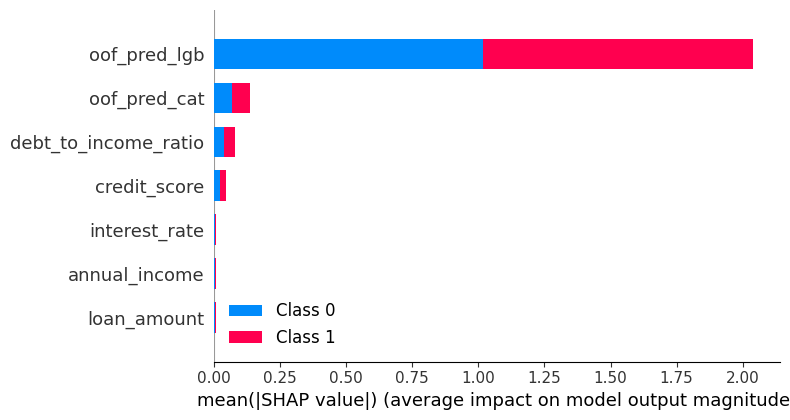

In [14]:
#SHAP
print("\nSHAP Explainability")
explainer = shap.TreeExplainer(final_lgb)

#Limit sample size for faster SHAP
sample_for_shap = X_meta_train if X_meta_train.shape[0] < 1000 else X_meta_train[np.random.RandomState(SEED).choice(X_meta_train.shape[0], 1000, replace=False)]
shap_values = explainer.shap_values(sample_for_shap)

#Summary plot
shap.summary_plot(shap_values, pd.DataFrame(sample_for_shap, columns=feature_names))
plt.show()

#Dependence plot for top feature
#mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
#top_feature = feature_names[np.argmax(mean_abs_shap)]
#print("Top feature by SHAP:", top_feature)
#shap.dependence_plot(top_feature, shap_values, pd.DataFrame(sample_for_shap, columns=feature_names))
#plt.show()

In [12]:
#Submission
submission = pd.DataFrame({
    'id': test_ids,
    'loan_paid_back': test_preds_final
})
submission.to_csv('submission.csv', index=False)
print(f"\nSaved submission.")


Saved submission.


In [13]:
df1 = pd.read_csv('submission.csv')
df1.head()

,id,loan_paid_back
0,593994,0.866036
1,593995,0.917433
2,593996,0.443337
3,593997,0.872124
4,593998,0.906054
